# Load Mnitst data
通过torchvision加载mnist数据集. 我们会判断是否已经通过网络下载过数据了，如果已经下载完成，则直接读取数据构造TorchLoader.

In [1]:
import os
import torch

is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(device)

# Load the MNIST dataset
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# 判断训练集是否存在如果存在就不再重复下载
# Load the MNIST dataset
data_path = './data'

# Always define trainset and testset
trainset = datasets.MNIST(data_path, download=not os.path.exists(data_path), train=True, transform=transform)
testset = datasets.MNIST(data_path, download=not os.path.exists(data_path), train=False, transform=transform)


# set batch size
batch_size = 256

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print('MNIST dataset loaded')
print(f'Train dataset shape: {trainset.data.shape}')
print(f"Test dataset shape: {testset.data.shape}")

cuda
MNIST dataset loaded
Train dataset shape: torch.Size([60000, 28, 28])
Test dataset shape: torch.Size([10000, 28, 28])


# 创建nn全连接神经网络，来实现数字分类，10分类

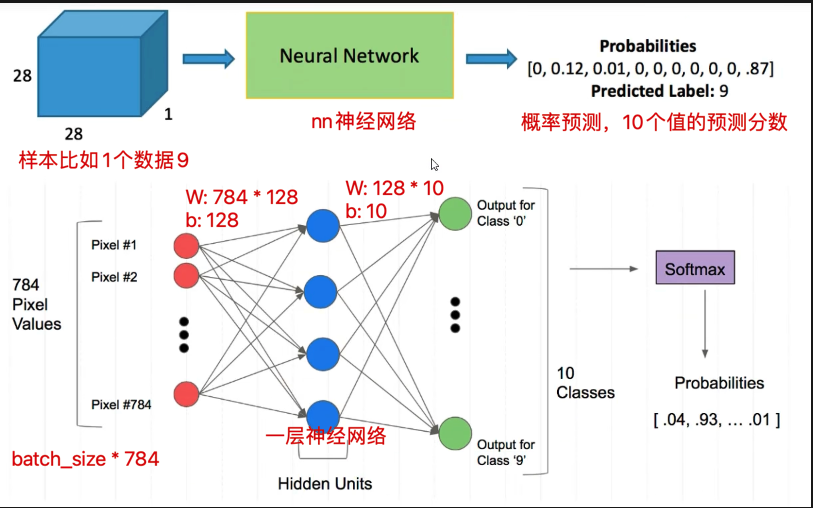

一开始是我们的输入层，也就是输入层有784个神经元(28 * 28)，也就是输入层有784个神经元。
输入层有784个神经元是因为MNIST数据集的图像是28x28像素的灰度图像，所以有784个像素点。
输出层有10个神经元是因为MNIST数据集有10个数字，也就是输出层有10个神经元。
中间层有128个神经元是因为我们选择128个神经元作为中间层。


## 创建一个mmode来简化代码
- 继承nn.Mdodule 
- 无需手写反向传播函数，nn.Module能够根据autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters和parameters方法访问，
  前者返回的是一个迭代器，后者返回的是一个列表

In [2]:
from torch import nn


class MnistModelNet(nn.Module):
    def __init__(self):
        super(MnistModelNet, self).__init__()
        self.hidden1 = nn.Linear(784, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.Dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        #dropout 一般添加在全连接层上
        x = self.Dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.Dropout(x)
        x = self.output(x)
        return x

model = MnistModelNet()
print(model)
for name, param in model.named_parameters():
    print(name, param, param.shape)

MnistModelNet(
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (Dropout): Dropout(p=0.5, inplace=False)
)
hidden1.weight Parameter containing:
tensor([[-0.0302,  0.0313, -0.0141,  ..., -0.0266,  0.0222,  0.0259],
        [-0.0215, -0.0312,  0.0287,  ...,  0.0178, -0.0243,  0.0029],
        [ 0.0198, -0.0093, -0.0346,  ..., -0.0216,  0.0131, -0.0187],
        ...,
        [-0.0322, -0.0115, -0.0063,  ...,  0.0006, -0.0128,  0.0279],
        [ 0.0089,  0.0186, -0.0241,  ...,  0.0225, -0.0288, -0.0224],
        [ 0.0298,  0.0241,  0.0328,  ...,  0.0260, -0.0101,  0.0326]],
       requires_grad=True) torch.Size([256, 784])
hidden1.bias Parameter containing:
tensor([-0.0187,  0.0346, -0.0347,  0.0232, -0.0297, -0.0264,  0.0252, -0.0170,
         0.0077, -0.0182,  0.0046,  0.0253, -0.0090,  0.0176,  0.0135, -0.0036,
        -0.

In [3]:
from idna import core
from torch.optim import SGD, Adam
from torch.nn import functional as F
# 训练模型
# 定义优化器
optimizer = SGD(model.parameters(), lr=0.01)
#optimizer = Adam(model.parameters(), lr=0.01)
# 定义损失函数
loss_function = F.cross_entropy
# 定义训练轮数
epochs = 50


def train(model, device, train_loader, optimizer, epoch):
    # 打印训练开始的信息
    print(f'Train Start Epoch: {epoch}')
    loss=0
    # 遍历训练数据集
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = len(data)
        # 将数据转移到指定设备上，并调整数据形状
        data, target = data.to(device).view(batch_size, -1), target.to(device).view(batch_size)
        # 将模型设置为训练模式
        model.train()
        # 将优化器的梯度清零
        optimizer.zero_grad()
        # 前向传播
        output = model(data)
        # 计算损失, output为模型输出，target为真实标签
        loss = F.cross_entropy(output, target)
        # 打印当前批次的损失
        #print(f'Epoch: {epoch}, Batch Idx:{batch_idx}, Loss: {loss.item()}')
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
    
    # 打印训练结束的信息
    print(f'Train End Epoch: {epoch}, Loss: {loss.item()}')

def test(model, device, test_loader):
    # 将模型设置为评估模式
    model.eval()
    # 初始化测试损失
    test_loss = 0
    # 初始化预测正确的个数
    correct = 0
    # 不计算梯度
    with torch.no_grad():
        # 遍历测试数据集
        for data, target in test_loader:
            # 获取当前批次的样本数
            batch_size = len(data)
            # 将数据移动到指定设备上，并调整形状
            data, target = data.to(device).view(batch_size, -1), target.to(device).view(batch_size)
            # 获取模型输出
            output = model(data)
            # 计算当前批次的损失
            test_loss += F.cross_entropy(output, target, reduction='sum')
            # 更新预测正确的个数
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum()

    # 计算平均损失
    test_loss = test_loss.item() / len(test_loader.dataset)
    # 打印测试结果
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct.item(), len(test_loader.dataset),
        100. * correct.item() / len(test_loader.dataset)))

# 训练模型
for epoch in range(epochs):
    model = model.to(device)
    # 训练模型
    train(model, device, trainloader, optimizer, epoch)
    # 测试模型
    test(model, device, testloader)




Train Start Epoch: 0
Train End Epoch: 0, Loss: 1.9183040857315063

Test set: Average loss: 1.7450, Accuracy: 6750/10000 (68%)

Train Start Epoch: 1
Train End Epoch: 1, Loss: 1.125722050666809

Test set: Average loss: 0.9093, Accuracy: 8009/10000 (80%)

Train Start Epoch: 2
Train End Epoch: 2, Loss: 0.7332242131233215

Test set: Average loss: 0.6328, Accuracy: 8400/10000 (84%)

Train Start Epoch: 3
Train End Epoch: 3, Loss: 0.7152712941169739

Test set: Average loss: 0.5128, Accuracy: 8654/10000 (87%)

Train Start Epoch: 4
Train End Epoch: 4, Loss: 0.5491487979888916

Test set: Average loss: 0.4468, Accuracy: 8797/10000 (88%)

Train Start Epoch: 5
Train End Epoch: 5, Loss: 0.5680974125862122

Test set: Average loss: 0.4084, Accuracy: 8873/10000 (89%)

Train Start Epoch: 6
Train End Epoch: 6, Loss: 0.6119067072868347

Test set: Average loss: 0.3762, Accuracy: 8960/10000 (90%)

Train Start Epoch: 7
Train End Epoch: 7, Loss: 0.4843239486217499

Test set: Average loss: 0.3563, Accuracy: 897

: 